In [2]:
# Load environment variables from .env
from dotenv import load_dotenv
import os

load_dotenv()  # reads the .env file
print("API key present?", bool(os.getenv("CENSUS_API_KEY")))


API key present? True


In [3]:
# !pip install census us pandas
from census import Census
from us import states
import pandas as pd
import os

# Put your key in an env var or paste as a string:
API_KEY = "2a9bc6c283d734640269520a6b34b19eafa59283"
YEAR = 2023  # ACS 5-year vintage

c = Census(API_KEY)


In [4]:
# Variables
# Population (ACS total pop at place level)
POP_VAR = "B01003_001E"

# ---- CHOOSE ONE numerator for "Black" ----
BLACK_VAR = "B02001_003E"   # Black or African American alone (any ethnicity)
# BLACK_VAR = "B03002_004E" # Black alone, NOT Hispanic (stricter). Use this line instead if you prefer.

def fetch_places_for_state(state_fips: str):
    """Return DataFrame of all places for a given state with NAME, pop, black."""
    vars_list = ("NAME", POP_VAR, BLACK_VAR)
    # '*' pulls all places in the state
    data = c.acs5.state_place(vars_list, state_fips, "*", year=YEAR)
    df = pd.DataFrame(data)
    # Coerce numerics
    for col in [POP_VAR, BLACK_VAR]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    # Add IDs
    df["state_fips"] = state_fips
    # place code is already in 'place' col; keep it
    return df


In [5]:
from census import Census
from us import states
import pandas as pd
import os, time

YEAR = 2023
API_KEY = "2a9bc6c283d734640269520a6b34b19eafa59283"

c = Census(API_KEY)

POP_VAR = "B01003_001E"
# Choose one of these for “Black”:
BLACK_VAR = "B02001_003E"    # Black alone (any ethnicity)
# BLACK_VAR = "B03002_004E"  # Black alone, not Hispanic

def fetch_places_for_state(state_fips: str, retries=2, pause=0.4):
    vars_list = ("NAME", POP_VAR, BLACK_VAR)
    for attempt in range(retries + 1):
        try:
            data = c.acs5.state_place(vars_list, state_fips, "*", year=YEAR)
            df = pd.DataFrame(data)
            # coerce numerics
            for col in (POP_VAR, BLACK_VAR):
                df[col] = pd.to_numeric(df[col], errors="coerce")
            df["state_fips"] = state_fips
            return df
        except Exception as e:
            if attempt < retries:
                time.sleep(pause * (attempt + 1))
            else:
                print(f"Skipping state {state_fips}: {e}")
                return None

# --- Smoke test with Maryland (24) ---
test_md = fetch_places_for_state("24")
if test_md is None or test_md.empty:
    raise RuntimeError("Smoke test failed: Maryland query returned nothing. Check API key and year.")

# --- Full run across states ---
frames = []
for st in states.STATES:  # 50 states (excludes DC; add it if you want)
    df = fetch_places_for_state(st.fips)
    if df is not None and not df.empty:
        frames.append(df)

# Optionally include DC
dc_df = fetch_places_for_state("11")
if dc_df is not None and not dc_df.empty:
    frames.append(dc_df)

if not frames:
    raise RuntimeError("All state queries failed. Likely API key issue or network problem.")

df = pd.concat(frames, ignore_index=True)

# Compute % Black and clean columns
df["pct_black"] = (df[BLACK_VAR] / df[POP_VAR]) * 100
df["pct_black"] = df["pct_black"].round(1)
city_state = df["NAME"].str.split(", ", n=1, expand=True)
df["city"] = city_state[0]
df["state_name"] = city_state[1]
df["population"] = df[POP_VAR].astype("Int64")

# Base universe (>= 100k)
base = df.loc[df["population"] >= 100_000,
              ["city","state_name","population","pct_black","state","place","state_fips"]].copy()

# Layers
layer_50 = base.loc[base["pct_black"] >= 50].sort_values(["pct_black","population"], ascending=[False, False])
layer_50.style.format({"population": "{:,}", "pct_black": "{:.1f}"})
layer_55 = base.loc[base["pct_black"] >= 55].sort_values(["pct_black","population"], ascending=[False, False])
layer_60 = base.loc[base["pct_black"] >= 60].sort_values(["pct_black","population"], ascending=[False, False])

print("Counts → base (>=100k):", len(base),
      "| >=50%:", len(layer_50),
      "| >=55%:", len(layer_55),
      "| >=60%:", len(layer_60))

# Save outputs
import pathlib
outdir = pathlib.Path("../data_clean")
outdir.mkdir(parents=True, exist_ok=True)
base.to_csv(outdir / "cities_over100k_all.csv", index=False)
layer_50.to_csv(outdir / "cities_over100k_50pct_black.csv", index=False)
layer_55.to_csv(outdir / "cities_over100k_55pct_black.csv", index=False)
layer_60.to_csv(outdir / "cities_over100k_60pct_black.csv", index=False)

# Show top rows for sanity
layer_50.head(10)


Counts → base (>=100k): 342 | >=50%: 15 | >=55%: 11 | >=60%: 8


,city,state_name,population,pct_black,state,place,state_fips
5949,South Fulton city,Georgia,109157,91.4,13,72122,13
14493,Jackson city,Mississippi,149827,81.8,28,36000,28
12829,Detroit city,Michigan,636644,76.8,26,22000,26
49,Birmingham city,Alabama,199322,67.1,01,07000,01
4957,Miami Gardens city,Florida,111264,63.4,12,45060,12
359,Montgomery city,Alabama,198440,63.0,01,51000,01
26665,Memphis city,Tennessee,629063,62.9,47,48000,47
11888,Baltimore city,Maryland,577193,60.0,24,04000,24
5421,Augusta-Richmond County consolidated governmen...,Georgia,201504,56.5,13,04204,13
11633,Shreveport city,Louisiana,183483,56.1,22,70000,22


In [6]:
import os
print("API key present?", bool(os.getenv("CENSUS_API_KEY")))


API key present? True


In [7]:
summary = pd.DataFrame({
    "Threshold": [">=100k", ">=50%", ">=55%", ">=60%"],
    "Count of Cities": [len(base), len(layer_50), len(layer_55), len(layer_60)]
})
summary


,Threshold,Count of Cities
0,>=100k,342
1,>=50%,15
2,>=55%,11
3,>=60%,8


In [8]:
# Round pct_black to one decimal for all layers
for df in [layer_50, layer_55, layer_60]:
    df["pct_black"] = df["pct_black"].round(1)

layer_60[["city","state_name","population","pct_black"]].sort_values("pct_black", ascending=False).head(10)


,city,state_name,population,pct_black
5949,South Fulton city,Georgia,109157,91.4
14493,Jackson city,Mississippi,149827,81.8
12829,Detroit city,Michigan,636644,76.8
49,Birmingham city,Alabama,199322,67.1
4957,Miami Gardens city,Florida,111264,63.4
359,Montgomery city,Alabama,198440,63.0
26665,Memphis city,Tennessee,629063,62.9
11888,Baltimore city,Maryland,577193,60.0


In [13]:
# --- Analysis: Average % Black by City Size Tier ---

# The `region` variable here represents *population tiers*, not geography.
# It categorizes all U.S. cities with ≥100K residents into 4 size groups.

avg_by_tier = base.groupby("region", observed=True)["pct_black"].mean().round(1)

# Display results with context
print("Average % of Black residents by city population tier (ACS 2023, cities ≥100K):\n")
display(avg_by_tier)

# Interpretation:
# - "100k–249k": smaller large cities; lower % Black on average
# - "250k–499k": mid-sized large cities
# - "500k–999k": large cities; often have the highest % Black share
# - "1M+": mega-cities; slightly lower due to racial/ethnic diversity


Average % of Black residents by city population tier (ACS 2023, cities ≥100K):



region
100k–249k    14.7
250k–499k    17.7
500k–999k    22.0
1M+          18.5
Name: pct_black, dtype: float64

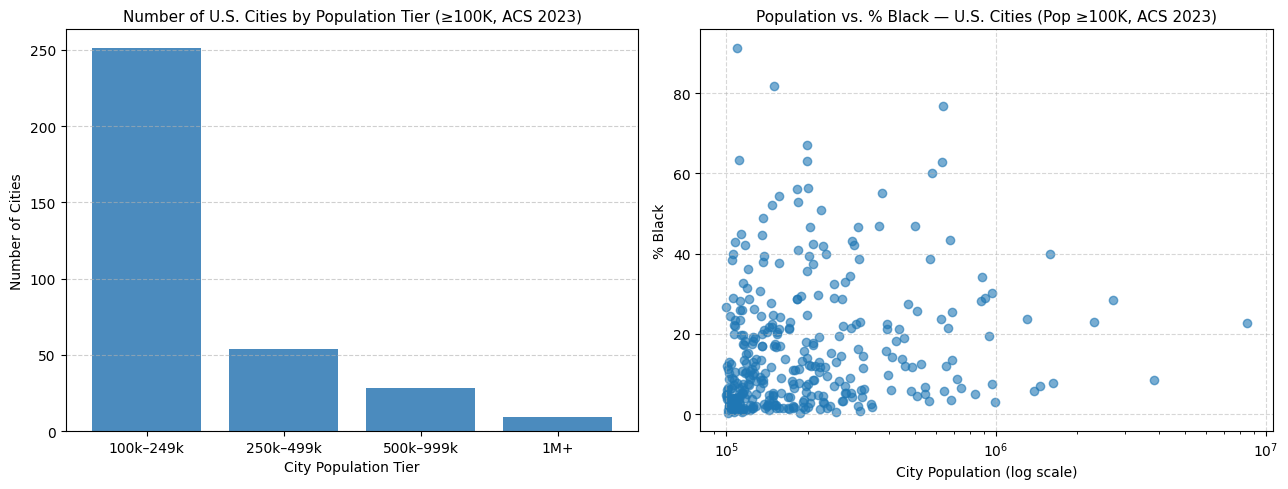


Interpretation:
- The left chart shows that most large U.S. cities fall in the 100k–249k population tier.
- The right chart shows that mid-sized and large cities (roughly 250k–1M) often have the highest % Black populations.
- The very largest metros (1M+) are more racially diverse overall, which lowers the average % Black share slightly.


In [14]:
# --- Summary Visualizations: City Demographics (Pop ≥100K) ---
import matplotlib.pyplot as plt

# Count of cities by size tier
city_counts = base["region"].value_counts().sort_index()

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# --- (Left) Bar chart: Number of cities by population tier ---
axes[0].bar(city_counts.index, city_counts.values, color="#4B8BBE")
axes[0].set_title("Number of U.S. Cities by Population Tier (≥100K, ACS 2023)", fontsize=11)
axes[0].set_xlabel("City Population Tier")
axes[0].set_ylabel("Number of Cities")
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
axes[0].tick_params(axis='x', rotation=0)

# --- (Right) Scatterplot: Population vs. % Black ---
axes[1].scatter(base["population"], base["pct_black"], alpha=0.6, color="#1f77b4")
axes[1].set_xscale("log")
axes[1].set_title("Population vs. % Black — U.S. Cities (Pop ≥100K, ACS 2023)", fontsize=11)
axes[1].set_xlabel("City Population (log scale)")
axes[1].set_ylabel("% Black")
axes[1].grid(True, linestyle="--", alpha=0.5)

# Adjust layout for readability
plt.tight_layout()
plt.show()

# Optional interpretation printout
print(
    "\nInterpretation:\n"
    "- The left chart shows that most large U.S. cities fall in the 100k–249k population tier.\n"
    "- The right chart shows that mid-sized and large cities (roughly 250k–1M) often have the highest % Black populations.\n"
    "- The very largest metros (1M+) are more racially diverse overall, which lowers the average % Black share slightly."
)


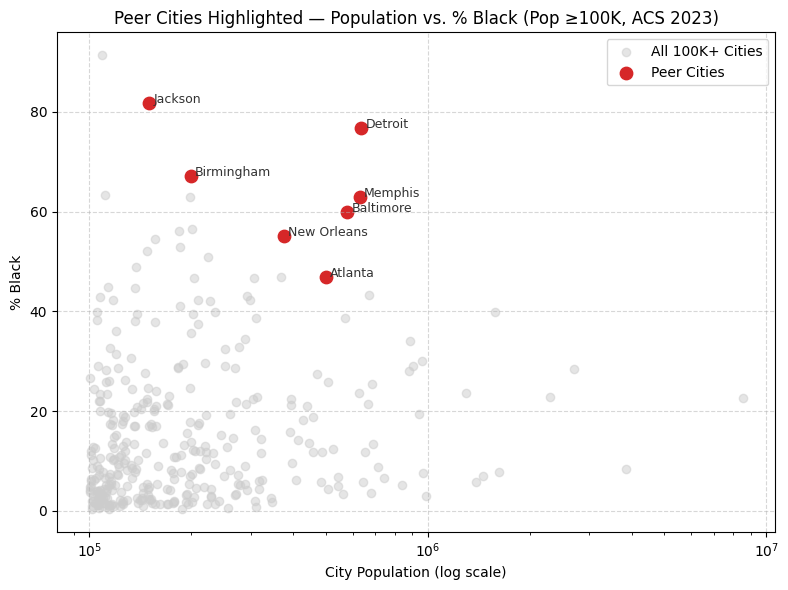

In [15]:
# --- Highlight Peer Cities on Population vs. % Black Scatterplot ---
import matplotlib.pyplot as plt

# Define your peer cities (match capitalization in your dataset)
peer_cities = [
    "Baltimore city",
    "Detroit city",
    "Memphis city",
    "Jackson city",
    "Birmingham city",
    "New Orleans city",
    "Atlanta city"
]

# Create base scatterplot
plt.figure(figsize=(8,6))
plt.scatter(base["population"], base["pct_black"], alpha=0.5, color="#cccccc", label="All 100K+ Cities")

# Highlight peer cities
peers_df = base[base["city"].isin(peer_cities)]
plt.scatter(peers_df["population"], peers_df["pct_black"], color="#d62728", s=80, label="Peer Cities")

# Annotate peer cities for visibility
for _, row in peers_df.iterrows():
    plt.text(
        row["population"] * 1.03,  # small offset so text doesn’t overlap point
        row["pct_black"],
        row["city"].replace(" city", ""),  # cleaner label
        fontsize=9,
        color="#333333"
    )

# Chart styling
plt.xscale("log")
plt.xlabel("City Population (log scale)")
plt.ylabel("% Black")
plt.title("Peer Cities Highlighted — Population vs. % Black (Pop ≥100K, ACS 2023)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# --- List all cities with population ≥100K and ≥51% Black ---
high_black_cities = (
    base.loc[base["pct_black"] >= 51, ["city", "state_name", "population", "pct_black"]]
    .sort_values(["pct_black", "population"], ascending=[False, False])
    .reset_index(drop=True)
)

# Round % Black for readability
high_black_cities["pct_black"] = high_black_cities["pct_black"].round(1)

# Display the table
print(f"Total cities with ≥51% Black population: {len(high_black_cities)}\n")
high_black_cities.head(25)  # show top 25 for readability


Total cities with ≥51% Black population: 15



,city,state_name,population,pct_black
0,South Fulton city,Georgia,109157,91.4
1,Jackson city,Mississippi,149827,81.8
2,Detroit city,Michigan,636644,76.8
3,Birmingham city,Alabama,199322,67.1
4,Miami Gardens city,Florida,111264,63.4
5,Montgomery city,Alabama,198440,63.0
6,Memphis city,Tennessee,629063,62.9
7,Baltimore city,Maryland,577193,60.0
8,Augusta-Richmond County consolidated governmen...,Georgia,201504,56.5
9,Shreveport city,Louisiana,183483,56.1


In [17]:
# --- Top 15 Largest U.S. Cities (Pop ≥100K) with % Black ---
top15_cities = (
    base.sort_values("population", ascending=False)
        .head(15)
        .loc[:, ["city", "state_name", "population", "pct_black"]]
        .copy()
)

# Round % Black for clarity
top15_cities["pct_black"] = top15_cities["pct_black"].round(1)

# Add a rank column
top15_cities.insert(0, "Rank", range(1, len(top15_cities) + 1))

# Display neatly
print("Top 15 U.S. Cities by Total Population (ACS 2023)\n")
top15_cities


Top 15 U.S. Cities by Total Population (ACS 2023)



,Rank,city,state_name,population,pct_black
19132,1,New York city,New York,8516202,22.7
2883,2,Los Angeles city,California,3857897,8.5
6710,3,Chicago city,Illinois,2707648,28.4
27601,4,Houston city,Texas,2300419,22.9
1226,5,Phoenix city,Arizona,1624832,7.8
24742,6,Philadelphia city,Pennsylvania,1582432,39.9
28353,7,San Antonio city,Texas,1458954,6.9
3306,8,San Diego city,California,1385061,5.7
27262,9,Dallas city,Texas,1299553,23.7
3316,10,San Jose city,California,990054,2.9


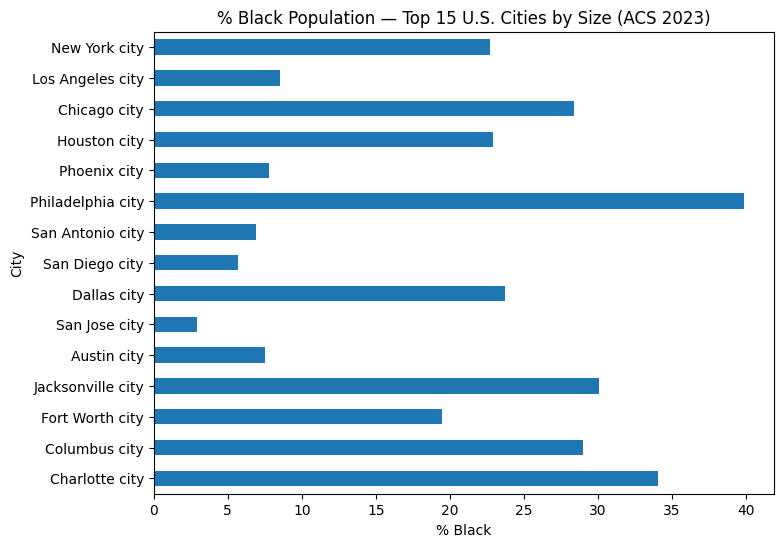

In [18]:
# Simple horizontal bar chart of % Black for top 15 cities
top15_cities.plot(
    x="city", y="pct_black", kind="barh", figsize=(8,6),
    color="#1f77b4", legend=False
)
plt.title("% Black Population — Top 15 U.S. Cities by Size (ACS 2023)")
plt.xlabel("% Black")
plt.ylabel("City")
plt.gca().invert_yaxis()
plt.show()


In [19]:
# --- Inspect column headers and basic structure ---
print("Column names:\n", df.columns.tolist())
print("\nShape:", df.shape)
df.head(2)


Column names:
 ['city', 'state_name', 'population', 'pct_black', 'state', 'place', 'state_fips']

Shape: (8, 7)


,city,state_name,population,pct_black,state,place,state_fips
5949,South Fulton city,Georgia,109157,91.4,13,72122,13
14493,Jackson city,Mississippi,149827,81.8,28,36000,28


In [21]:
# Basic regional mapping
south = ["AL","AR","FL","GA","KY","LA","MS","NC","SC","TN","TX","VA","WV","MD","DE","DC"]
base["region"] = base["state_name"].map(lambda s: "South" if s in south else "Other")

base.groupby("region")["pct_black"].mean().round(1)


region
Other    15.9
Name: pct_black, dtype: float64

In [22]:
base["black_pop"] = base["population"] * base["pct_black"] / 100
top_black_pop = base.sort_values("black_pop", ascending=False).head(15)
top_black_pop[["city","state_name","population","black_pop","pct_black"]]


,city,state_name,population,black_pop,pct_black
19132,New York city,New York,8516202,1933177.854,22.7
6710,Chicago city,Illinois,2707648,768972.032,28.4
24742,Philadelphia city,Pennsylvania,1582432,631390.368,39.9
27601,Houston city,Texas,2300419,526795.951,22.9
12829,Detroit city,Michigan,636644,488942.592,76.8
26665,Memphis city,Tennessee,629063,395680.627,62.9
11888,Baltimore city,Maryland,577193,346315.8,60.0
2883,Los Angeles city,California,3857897,327921.245,8.5
27262,Dallas city,Texas,1299553,307994.061,23.7
19786,Charlotte city,North Carolina,886283,302222.503,34.1


In [27]:
# Step 1 — Compute descriptive stats (keep this line)
base["black_index"].describe()


count    342.000000
mean       1.167978
std        1.156743
min        0.022059
25%        0.310662
50%        0.786765
75%        1.647059
max        6.720588
Name: black_index, dtype: float64

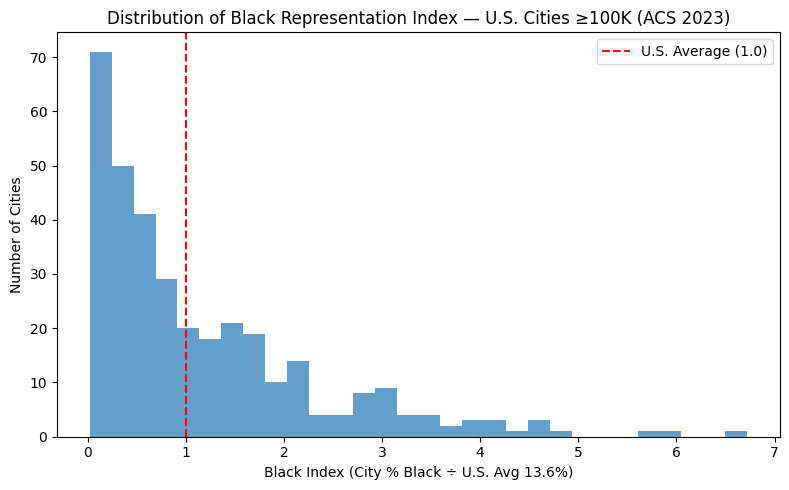

In [28]:
# Step 2 — Visualize distribution of Black Index
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(base["black_index"], bins=30, color="#1f77b4", alpha=0.7)
plt.axvline(1.0, color="red", linestyle="--", label="U.S. Average (1.0)")
plt.title("Distribution of Black Representation Index — U.S. Cities ≥100K (ACS 2023)")
plt.xlabel("Black Index (City % Black ÷ U.S. Avg 13.6%)")
plt.ylabel("Number of Cities")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
# --- Top 10 Cities with Highest Black Index (most overrepresented) ---
top_black_index = (
    base.sort_values("black_index", ascending=False)
        .loc[:, ["city", "state_name", "population", "pct_black", "black_index"]]
        .head(10)
        .reset_index(drop=True)
)

top_black_index["pct_black"] = top_black_index["pct_black"].round(1)
top_black_index["black_index"] = top_black_index["black_index"].round(2)

print("Top 10 Cities by Black Representation Index (≥100K, ACS 2023)\n")
top_black_index


Top 10 Cities by Black Representation Index (≥100K, ACS 2023)



,city,state_name,population,pct_black,black_index
0,South Fulton city,Georgia,109157,91.4,6.72
1,Jackson city,Mississippi,149827,81.8,6.01
2,Detroit city,Michigan,636644,76.8,5.65
3,Birmingham city,Alabama,199322,67.1,4.93
4,Miami Gardens city,Florida,111264,63.4,4.66
5,Montgomery city,Alabama,198440,63.0,4.63
6,Memphis city,Tennessee,629063,62.9,4.62
7,Baltimore city,Maryland,577193,60.0,4.41
8,Augusta-Richmond County consolidated governmen...,Georgia,201504,56.5,4.15
9,Shreveport city,Louisiana,183483,56.1,4.12
